<h1><center>CSE391 programming for data science</center></h1>

<h1><center>Lecture 23</center></h1>
<h1><center>April 30 ,2018 </center></h1>




# [Download Cytoscape](http://www.cytoscape.org/) 

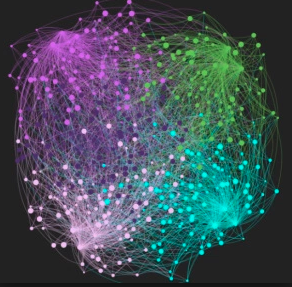

# Below script from previous lecture
## two points left

In [ ]:
# Implementation of a simple MLP network with one hidden layer. Tested on the iris data set.
# Requires: numpy, sklearn>=0.18.1, tensorflow>=1.0

# NOTE: In order to make the code simple, we rewrite x * W_1 + b_1 = x' * W_1'
# where x' = [x | 1] and W_1' is the matrix W_1 appended with a new row with elements b_1's.
# Similarly, for h * W_2 + b_2

# author :vinhkhuc  Feb 26, 2017
import tensorflow as tf
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)


def init_weights(shape):
    """ Weight initialization """
    weights = tf.random_normal(shape, stddev=0.1)
    return tf.Variable(weights)

def forwardprop(X, w_1, w_2):
    """
    Forward-propagation.
    IMPORTANT: yhat is not softmax since TensorFlow's softmax_cross_entropy_with_logits() does that internally.
    """
    h    = tf.nn.sigmoid(tf.matmul(X, w_1))  # The \sigma function
    yhat = tf.matmul(h, w_2)  # The \varphi function
    return yhat

def get_iris_data():
    """ Read the iris data set and split them into training and test sets """
    iris   = datasets.load_iris()
    data   = iris["data"]
    target = iris["target"]
    print(target)
    # Prepend the column of 1s for bias
    N, M  = data.shape
    all_X = np.ones((N, M + 1))
    all_X[:, 1:] = data

    # Convert into one-hot vectors
    num_labels = len(np.unique(target))
    all_Y = np.eye(num_labels)[target]  # One liner trick!
    return train_test_split(all_X, all_Y, test_size=0.33, random_state=RANDOM_SEED)

def main():
    train_X, test_X, train_y, test_y = get_iris_data()

    # Layer's sizes
    x_size = train_X.shape[1]   # Number of input nodes: 4 features and 1 bias
    h_size = 256                # Number of hidden nodes
    y_size = train_y.shape[1]   # Number of outcomes (3 iris flowers)

    # Symbols
    X = tf.placeholder("float", shape=[None, x_size])
    y = tf.placeholder("float", shape=[None, y_size])

    # Weight initializations
    w_1 = init_weights((x_size, h_size))
    w_2 = init_weights((h_size, y_size))

    # Forward propagation
    yhat    = forwardprop(X, w_1, w_2)
    predict = tf.argmax(yhat, axis=1)

    # Backward propagation
    cost    = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=yhat))
    updates = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

    # Run SGD
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    for epoch in range(100):
        # Train with each example
        for i in range(len(train_X)):
            sess.run(updates, feed_dict={X: train_X[i: i + 1], y: train_y[i: i + 1]})

        train_accuracy = np.mean(np.argmax(train_y, axis=1) ==
                                 sess.run(predict, feed_dict={X: train_X, y: train_y}))
        test_accuracy  = np.mean(np.argmax(test_y, axis=1) ==
                                 sess.run(predict, feed_dict={X: test_X, y: test_y}))

        print("Epoch = %d, train accuracy = %.2f%%, test accuracy = %.2f%%"
              % (epoch + 1, 100. * train_accuracy, 100. * test_accuracy))

    sess.close()

if __name__ == '__main__':
    main()

# Understanding one-hot encoding
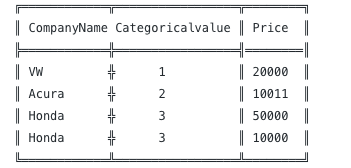
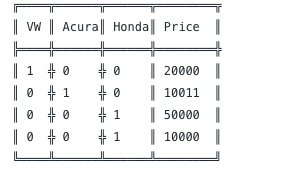

In [ ]:
target = [0,0,1,1,0,2,0,1,1]
num_labels = len(np.unique(target))
all_Y = np.eye(num_labels)[target]

print(all_Y)

# Understanding Epoch
- One cycle through the entire training dataset is called a training epoch
- example: Say you have a dataset of 10 examples (or samples). You have a batch size of 2, and you've specified you want the algorithm to run for 3 epochs. Therefore, in each epoch, you have 5 batches (10/2 = 5). Each batch gets passed through the algorithm, therefore you have 5 iterations per epoch. Since you've specified 3 epochs, you have a total of 15 iterations (5*3 = 15) for training. SRC: khon stackflow

# Recurrent Neural Networks 
### applications:
- machine translation
- speech recognition
- language modelling
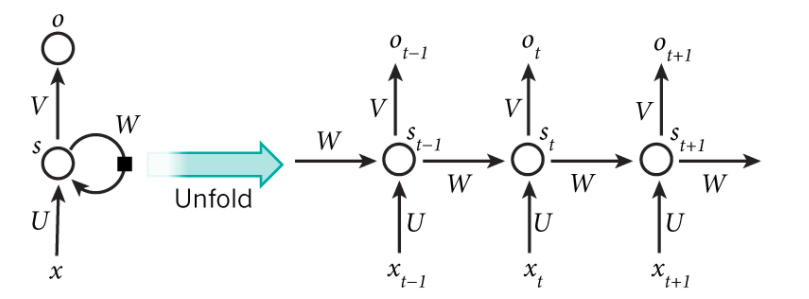

SRC: Nature

- $x_t$ input
- $s_t$ hidden unit or the memory
-  $o_t$ output unit
- RNN shares the parameters $H,W, V$ accress all steps


#  Two important variations of RNNs to combat the vanishing gradiant issue of RNN:

- Long Short-Term Memory Units (LSTMs)
- Gated Recurrent Units (GRUs)

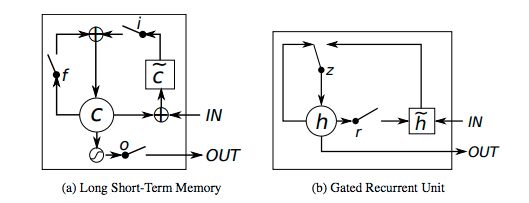


# Training a GUR model
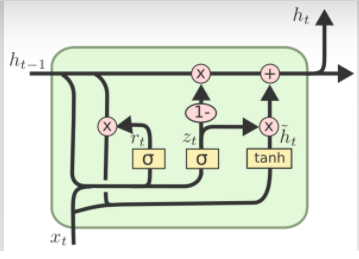
[SRC](https://www.data-blogger.com/2017/08/27/gru-implementation-tensorflow/)


# Formulas
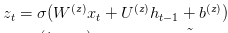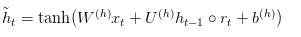


# ## The below code learns using GRU to add to binary numbers.
SRC Kevin Jacobs

In [ ]:
#%% (0) Important libraries
import tensorflow as tf
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from IPython import display
% matplotlib inline

#%% (1) Dataset creation.

def as_bytes(num, final_size):
    """Converts an integer to a reversed bitstring (of size final_size).
    
    Arguments
    ---------
    num: int
        The number to convert.
    final_size: int
        The length of the bitstring.
        
    Returns
    -------
    list:
        A list which is the reversed bitstring representation of the given number.
        
    Examples
    --------
    >>> as_bytes(3, 4)
    [1, 1, 0, 0]
    >>> as_bytes(3, 5)
    [1, 1, 0, 0, 0]
    """
    res = []
    for _ in range(final_size):
        res.append(num % 2)
        num //= 2
    return res

def generate_example(num_bits):
    """Generate an example addition.
    
    Arguments
    ---------
    num_bits: int
        The number of bits to use.
        
    Returns
    -------
    a: list
        The first term (represented as reversed bitstring) of the addition.
    b: list
        The second term (represented as reversed bitstring) of the addition.
    c: list
        The addition (a + b) represented as reversed bitstring.
        
    Examples
    --------
    >>> np.random.seed(4)
    >>> a, b, c = generate_example(3)
    >>> a
    [0, 1, 0]
    >>> b
    [0, 1, 0]
    >>> c
    [1, 0, 0]
    >>> # Notice that these numbers are represented as reversed bitstrings)
    """
    a = random.randint(0, 2**(num_bits - 1) - 1)
    b = random.randint(0, 2**(num_bits - 1) - 1)
    res = a + b
    return (as_bytes(a,  num_bits),
            as_bytes(b,  num_bits),
            as_bytes(res,num_bits))

def generate_batch(num_bits, batch_size):
    """Generates instances of the addition problem.
    
    Arguments
    ---------
    num_bits: int
        The number of bits to use for each number.
    batch_size: int
        The number of examples to generate.
    
    Returns
    -------
    x: np.array
        Two numbers to be added represented as bits (in reversed order).
        Shape: b, i, n
        Where:
            b is bit index from the end.
            i is example idx in batch.
            n is one of [0,1] depending for first and second summand respectively.
    y: np.array
        The result of the addition.
        Shape: b, i, n
        Where:
            b is bit index from the end.
            i is example idx in batch.
            n is always 0 since there is only one result.
    """
    x = np.empty((batch_size, num_bits, 2))
    y = np.empty((batch_size, num_bits, 1))

    for i in range(batch_size):
        a, b, r = generate_example(num_bits)
        x[i, :, 0] = a
        x[i, :, 1] = b
        y[i, :, 0] = r
    return x, y

# Configuration
batch_size = 100
time_size = 5

# Generate a test set and a train set containing 100 examples of numbers represented in 5 bits
X_train, Y_train = generate_batch(time_size, batch_size)
X_test, Y_test = generate_batch(time_size, batch_size)

#%% (2) Model definition.

import tensorflow as tf

class GRU:
    """Implementation of a Gated Recurrent Unit (GRU) as described in [1].
    
    [1] Chung, J., Gulcehre, C., Cho, K., & Bengio, Y. (2014). Empirical evaluation of gated recurrent neural networks on sequence modeling. arXiv preprint arXiv:1412.3555.
    
    Arguments
    ---------
    input_dimensions: int
        The size of the input vectors (x_t).
    hidden_size: int
        The size of the hidden layer vectors (h_t).
    dtype: obj
        The datatype used for the variables and constants (optional).
    """
    
    def __init__(self, input_dimensions, hidden_size, dtype=tf.float64):
        self.input_dimensions = input_dimensions
        self.hidden_size = hidden_size
        
        # Weights for input vectors of shape (input_dimensions, hidden_size)
        self.Wr = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wr')
        self.Wz = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wz')
        self.Wh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wh')
        
        # Weights for hidden vectors of shape (hidden_size, hidden_size)
        self.Ur = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Ur')
        self.Uz = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Uz')
        self.Uh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Uh')
        
        # Biases for hidden vectors of shape (hidden_size,)
        self.br = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='br')
        self.bz = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='bz')
        self.bh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='bh')
        
        # Define the input layer placeholder
        self.input_layer = tf.placeholder(dtype=tf.float64, shape=(None, None, input_dimensions), name='input')
        
        # Put the time-dimension upfront for the scan operator
        self.x_t = tf.transpose(self.input_layer, [1, 0, 2], name='x_t')
        
        # A little hack (to obtain the same shape as the input matrix) to define the initial hidden state h_0
        self.h_0 = tf.matmul(self.x_t[0, :, :], tf.zeros(dtype=tf.float64, shape=(input_dimensions, hidden_size)), name='h_0')
        
        # Perform the scan operator
        self.h_t_transposed = tf.scan(self.forward_pass, self.x_t, initializer=self.h_0, name='h_t_transposed')
        
        # Transpose the result back
        self.h_t = tf.transpose(self.h_t_transposed, [1, 0, 2], name='h_t')

    def forward_pass(self, h_tm1, x_t):
        """Perform a forward pass.
        
        Arguments
        ---------
        h_tm1: np.matrix
            The hidden state at the previous timestep (h_{t-1}).
        x_t: np.matrix
            The input vector.
        """
        # Definitions of z_t and r_t
        z_t = tf.sigmoid(tf.matmul(x_t, self.Wz) + tf.matmul(h_tm1, self.Uz) + self.bz)
        r_t = tf.sigmoid(tf.matmul(x_t, self.Wr) + tf.matmul(h_tm1, self.Ur) + self.br)
        
        # Definition of h~_t
        h_proposal = tf.tanh(tf.matmul(x_t, self.Wh) + tf.matmul(tf.multiply(r_t, h_tm1), self.Uh) + self.bh)
        
        # Compute the next hidden state
        h_t = tf.multiply(1 - z_t, h_tm1) + tf.multiply(z_t, h_proposal)
        
        return h_t
    
#%% (3) Initialize and train the model.

# The input has 2 dimensions: dimension 0 is reserved for the first term and dimension 1 is reverved for the second term
input_dimensions = 2

# Arbitrary number for the size of the hidden state
hidden_size = 16

# Initialize a session
session = tf.Session()

# Create a new instance of the GRU model
gru = GRU(input_dimensions, hidden_size)

# Add an additional layer on top of each of the hidden state outputs
W_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(hidden_size, 1), mean=0, stddev=0.01))
b_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(1,), mean=0, stddev=0.01))
output = tf.map_fn(lambda h_t: tf.matmul(h_t, W_output) + b_output, gru.h_t)

# Create a placeholder for the expected output
expected_output = tf.placeholder(dtype=tf.float64, shape=(batch_size, time_size, 1), name='expected_output')

# Just use quadratic loss
loss = tf.reduce_sum(0.5 * tf.pow(output - expected_output, 2)) / float(batch_size)

# Use the Adam optimizer for training
train_step = tf.train.AdamOptimizer().minimize(loss)

# Initialize all the variables
init_variables = tf.global_variables_initializer()
session.run(init_variables)

# Initialize the losses
train_losses = []
validation_losses = []

# Perform all the iterations
for epoch in range(500):
    # Compute the losses
    _, train_loss = session.run([train_step, loss], feed_dict={gru.input_layer: X_train, expected_output: Y_train})
    validation_loss = session.run(loss, feed_dict={gru.input_layer: X_test, expected_output: Y_test})
    
    # Log the losses
    train_losses += [train_loss]
    validation_losses += [validation_loss]
    
    # Display an update every 50 iterations
    if epoch % 50 == 0:
        plt.plot(train_losses, '-b', label='Train loss')
        plt.plot(validation_losses, '-r', label='Validation loss')
        plt.legend(loc=0)
        plt.title('Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.show()
        print('Iteration: %d, train loss: %.4f, test loss: %.4f' % (epoch, train_loss, validation_loss))
    
#%% (4) Manually evaluate the model.
    
# Define two numbers a and b and let the model compute a + b
a = 1024
b = 16

# The model is independent of the sequence length! Now we can test the model on even longer bitstrings
bitstring_length = 20

# Create the feature vectors    
X_custom_sample = np.vstack([as_bytes(a, bitstring_length), as_bytes(b, bitstring_length)]).T
X_custom = np.zeros((1,) + X_custom_sample.shape)
X_custom[0, :, :] = X_custom_sample

# Make a prediction by using the model
y_predicted = session.run(output, feed_dict={gru.input_layer: X_custom})
# Just use a linear class separator at 0.5
y_bits = 1 * (y_predicted > 0.5)[0, :, 0]
# Join and reverse the bitstring
y_bitstr = ''.join([str(int(bit)) for bit in y_bits.tolist()])[::-1]
# Convert the found bitstring to a number
y = int(y_bitstr, 2)

# Print out the prediction
print(y) # Yay! This should equal 1024 + 16 = 1040

# What will be the future of Deep Learning ?
 Well let's see what leaders say:
 
 [Deep Learning and the Future of Artificial Intelligence](https://www.youtube.com/watch?v=RM-Jtc2ryfM)

[From Deep learning of dientagled Representation to cognition](https://www.youtube.com/watch?v=Yr1mOzC93xs&t=282s)

 [Geoffrey Hinton: The Foundations of Deep Learning](https://www.youtube.com/watch?v=zl99IZvW7rE)